<a href="https://colab.research.google.com/github/vicpb/deep-learning-cnn-udemy/blob/main/SpamDetectionCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# install tensforflow
!pip install -q tensorflow
import tensorflow as tf
print(tf.__version__)

2.5.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding
from tensorflow.keras.models import Model

In [3]:
# Unfortunately this URL doesn't work directly with pd.read_csv
!wget https://lazyprogrammer.me/course_files/spam.csv

--2021-07-12 14:54:21--  https://lazyprogrammer.me/course_files/spam.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 503663 (492K) [text/csv]
Saving to: ‘spam.csv.2’

spam.csv.2          100%[===================>] 491.86K  --.-KB/s    in 0.04s   

2021-07-12 14:54:21 (10.8 MB/s) - ‘spam.csv.2’ saved [503663/503663]



In [4]:
df = pd.read_csv('spam.csv', encoding='ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [6]:
# drop unnecessary columns
df = df.drop(["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"], axis=1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns to something better
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels
df['b_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
Y = df['b_labels'].values

In [11]:
# split up the data
df_train, df_test, Ytrain, Ytest, = train_test_split(df['data'], Y, test_size=0.33)

In [12]:
# Convert sentences to sequences
MAX_VOCAB_SIZE = 20000
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(df_train)
sequences_train = tokenizer.texts_to_sequences(df_train)
sequences_test = tokenizer.texts_to_sequences(df_test)

In [13]:
# get word -> integer mapping
word2idx = tokenizer.word_index
V = len(word2idx)
print("Found %s unique tokens. " % V)

Found 7207 unique tokens. 


In [14]:
# pad sequences so that we get a N x T matrix
data_train = pad_sequences(sequences_train)
print("Shape of data train tensor: ", data_train.shape)

# get sequence length
T = data_train.shape[1]

Shape of data train tensor:  (3733, 189)


In [15]:
data_test = pad_sequences(sequences_test, maxlen=T)
print("Shape of data test tensor: ", data_test.shape)

Shape of data test tensor:  (1839, 189)


In [16]:
# Create the model
# We get to choose embedding dimensionality
D = 20

# Note: we actually want to the size of the embedding to (V + 1) x D,
# because the first index starts from 1 and not 0.
# Thus, if the final index of the embedding matrix is V,
# then it actually must have size V + 1.

i = Input(shape=(T,))
x = Embedding(V + 1, D)(i)
x = Conv1D(32, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i, x)

In [17]:
# Compile and fit
model.compile(
    loss = 'binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print('Training model...')
r = model.fit(
    data_train,
    Ytrain,
    epochs=5,
    validation_data=(data_test, Ytest)
)

Training model...
Epoch 1/5
117/117 [==============================] - 4s 23ms/step - loss: 0.3928 - accuracy: 0.8634 - val_loss: 0.2828 - val_accuracy: 0.8619
Epoch 2/5
117/117 [==============================] - 2s 20ms/step - loss: 0.1678 - accuracy: 0.9229 - val_loss: 0.0786 - val_accuracy: 0.9777
Epoch 3/5
117/117 [==============================] - 2s 20ms/step - loss: 0.0225 - accuracy: 0.9949 - val_loss: 0.0838 - val_accuracy: 0.9782
Epoch 4/5
117/117 [==============================] - 2s 21ms/step - loss: 0.0064 - accuracy: 0.9987 - val_loss: 0.0770 - val_accuracy: 0.9815
Epoch 5/5
117/117 [==============================] - 2s 21ms/step - loss: 0.0033 - accuracy: 0.9995 - val_loss: 0.0974 - val_accuracy: 0.9793


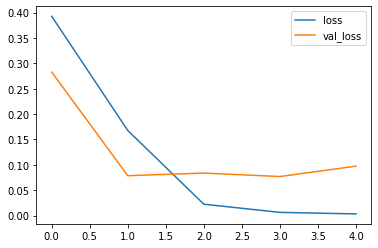

In [18]:
# Plot loss per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

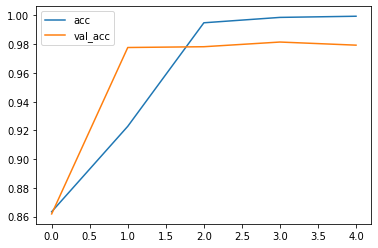

In [19]:
# Plot accuracy per iteration
import matplotlib.pyplot as plt
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()